In [1]:
import pandas as pd

df = pd.read_csv('../data/AMAZON-REVIEW-DATA-REGRESSION.csv', header=0)
df.head()

reviewText  \
0  Stuck with this at work, slow and we still got...   
1  I use parallels every day with both my persona...   
2  Barbara Robbins\n\nI've used TurboTax to do ou...   
3  I have been using this software security for y...   
4  If you want your computer hijacked and slowed ...   

                                             summary  verified        time  \
0                                  Use SEP or Mcafee     False  1464739200   
1                                       Use it daily     False  1332892800   
2                                    Helpful Product      True  1398816000   
3                                         Five Stars      True  1430784000   
4  ... hijacked and slowed to a crawl Windows 10 ...     False  1508025600   

   rating  log_votes  
0     1.0        0.0  
1     5.0        0.0  
2     4.0        0.0  
3     5.0        0.0  
4     1.0        0.0

In [2]:
df["log_votes"].min()

0.0

In [3]:
df["log_votes"].max()

7.799753318287247

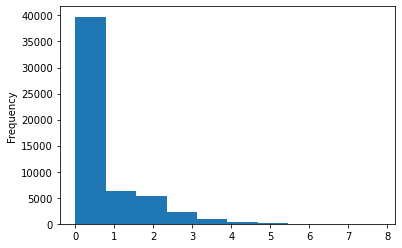

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

### Printing the sum of na for every column in data frame


In [5]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


In [6]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravikiran.bhonagiri\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravikiran.bhonagiri\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


True

### Preprocessing the string data 


In [7]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "summary", "time", "rating"]],
                                                  df["log_votes"],
                                                  test_size=0.10,
                                                  shuffle=True,
                                                  random_state=324
                                                 )

In [9]:
print("Processing the reviewText fields")
X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())

print("Processing the summary fields")
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

Processing the reviewText fields
Processing the summary fields


In [10]:
# Grab model features/inputs and target/output
numerical_features = ['time',
                      'rating']

text_features = ['summary',
                 'reviewText']

model_features = numerical_features + text_features
model_target = 'log_votes'

### Building the data pipelines 
### Trying different Algorithms
### a. Linear Regression
### b. Ridge
### c. Lasso 
### d. ElasticNet 

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_scaler', MinMaxScaler())
])
# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=50))
])

# Preprocess 2nd text feature (larger vocabulary)
text_precessor_1 = Pipeline([
    ('text_vect_1', CountVectorizer(binary=True, max_features=150))
])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
]) 

### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lr', LinearRegression())
])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'rating']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('lr', LinearRegression())])

In [12]:
# Fit the Pipeline to training data
pipeline.fit(X_train[model_features], y_train.values)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'rating']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('lr', LinearRegression())])

<b>LinearRegression</b>
Let's first fit LinearRegression from Sklearn library, and check the performance on the validation dataset. Using the coef_ atribute, we can also print the learned weights of the model.

Find more details on LinearRegression here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lrRegressor_val_predictions = pipeline.predict(X_val[model_features])
print("LinearRegression on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lrRegressor_val_predictions),r2_score(y_val, lrRegressor_val_predictions)))
print("LinearRegression model weights: \n", pipeline.named_steps['lr'].coef_)

LinearRegression on Validation: Mean_squared_error: 0.591002,  R_square_score: 0.356090
LinearRegression model weights: 
 [-1.74577245e+00 -4.16698691e-01  6.55478179e-02 -2.35272587e-02
  8.61182130e-02 -1.01365634e-02  7.93570945e-02  1.00553640e-01
  5.29775822e-02  2.05177288e-02  5.73231401e-02  2.22065171e-01
  9.93801540e-02 -1.37718544e-02 -4.06337509e-02 -1.06054584e-04
  4.40533068e-02  9.05416164e-02  2.17865284e-02  1.26157731e-02
 -2.25996291e-02  8.55590009e-03  2.45830779e-02 -2.33422363e-02
 -3.30934184e-02 -9.93257374e-03 -1.51382179e-01 -3.76458293e-02
  6.49464633e-02 -1.17080180e-02  1.08904281e-02  1.58619482e-02
 -4.96701343e-02 -5.60326944e-02  5.79966953e-02 -8.74212104e-02
  1.68585018e-02 -4.05427013e-02  2.67941221e-02  4.66072220e-02
 -9.31192147e-03  1.16266401e-01  2.62079452e-02 -2.14293910e-02
 -1.19377748e-02 -4.02070684e-02 -5.45584216e-02 -1.20253346e-01
  1.28724719e-02  5.21390340e-02 -1.36309560e-02  8.86498669e-02
  5.41902858e-03 -4.70436895e-02 

<b>Ridge (Linear Regression with L2 regularization)</b>
Let's now fit Ridge from Sklearn library, and check the performance on the validation dataset.

Find more details on Ridge here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

To improve the performance of a LinearRegression model, Ridge is tuning model complexity by adding a $L_2$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  {alpha}∗||\textbf{w}||_2^2$$
where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_2^2 = \sum \textbf{w}_i^2$.

The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of $alpha$, weaker regularization; larger value of $alpha$, stronger regularization.

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# Let's update the pipeline with Ridge regression model
ridge_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('ridge', Ridge(alpha = 100))
])

ridge_pipeline.fit(X_train[model_features], y_train.values)
ridgeRegressor_val_predictions = ridge_pipeline.predict(X_val[model_features])

print("Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, ridgeRegressor_val_predictions),r2_score(y_val, ridgeRegressor_val_predictions)))

print("Ridge model weights: \n", ridge_pipeline.named_steps['ridge'].coef_)



Ridge on Validation: Mean_squared_error: 0.589703,  R_square_score: 0.357506
Ridge model weights: 
 [-1.62648079e+00 -4.04075727e-01  5.80555136e-02 -2.25636900e-02
  7.87477589e-02 -1.08407800e-02  5.89973415e-02  8.22764393e-02
  4.35481972e-02  1.30580769e-02  4.91960821e-02  1.56938051e-01
  3.43309430e-02 -1.37064320e-02 -4.37536214e-02 -4.01058625e-03
  3.66347929e-02  7.18727198e-02  1.44831335e-02  4.29764227e-03
 -2.19734716e-02 -2.03028626e-03  8.37484300e-03 -2.42634475e-02
 -3.31531654e-02 -9.63737330e-03 -1.21653138e-01 -7.14120658e-02
  5.41043296e-02 -8.08645531e-03  8.39674407e-03  1.22995022e-02
 -4.82867362e-02 -5.34970309e-02  5.08611003e-02 -4.54669660e-02
  1.89929964e-02 -4.23438430e-02 -2.90360249e-02  3.36979899e-02
 -1.18758950e-02  9.45785602e-02 -2.20714325e-02 -1.74710998e-02
 -1.45627870e-02 -3.34926315e-02 -5.03281331e-02 -8.39422441e-02
  6.64784465e-03  4.44580450e-02 -1.77632022e-02  7.80698125e-02
  4.98607300e-03 -4.81647539e-02  8.46607016e-02  6.294

<b>LASSO (Linear Regression with L1 regularization)</b>
Let's also fit Lasso from Sklearn library, and check the performance on the validation dataset.

Find more details on Lasso here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Lasso is tuning model complexity by adding a $L_1$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  alpha∗||\textbf{w}||_1$$
where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_1 = \sum |\textbf{w}_i|$.

Again, the strength of the regularization is controlled by the regularizer parameter, $alpha$. Due to the geometry of $L_1$ norm, with Lasso, some of the weights will shrink all the way to 0, leading to sparsity - some of the features are not contributing to the model afterall!

In [15]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

# Let's update the pipeline with Lasso regression model
lasso_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lasso', Lasso(alpha = 0.001))
])

lasso_pipeline.fit(X_train[model_features], y_train.values)
lassoRegressor_val_predictions = lasso_pipeline.predict(X_val[model_features])

print("Lasso on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lassoRegressor_val_predictions),r2_score(y_val, lassoRegressor_val_predictions)))

print("Lasso model weights: \n", lasso_pipeline.named_steps['lasso'].coef_)

Lasso on Validation: Mean_squared_error: 0.589867,  R_square_score: 0.357327
Lasso model weights: 
 [-1.72010524e+00 -3.89067686e-01  2.58213525e-02 -0.00000000e+00
  3.82842552e-02 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.06602376e-02  1.26472385e-01
  0.00000000e+00 -0.00000000e+00 -2.50955076e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.63960564e-02 -5.02315491e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  3.47943828e-02 -1.61006740e-02
  0.00000000e+00 -7.44345517e-03 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  1.95457533e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -5.88222939e-05  2.42462224e-02
  0.00000000e+00 -1.67083722e-02  7.65288954e-02  5.111

<b>ElasticNet (Linear Regression with L2 and L1 regularization)</b>
Let's finally try ElasticNet from Sklearn library, and check the performance on the validation dataset.

Find more details on ElasticNet here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

ElasticNet is tuning model complexity by adding both $L_2$ and $L_1$ penalty scores for complexity to the model's cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  0.5*alpha∗(1-\textit{l1}_{ratio})||\textbf{w}||_2^2 + alpha∗\textit{l1}_{ratio}∗||\textbf{w}||_1$$
and using two parameters, $alpha$ and $\textit{l1}_{ratio}$, to control the strength of the regularization.

In [16]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

# Let's update the pipeline with ElasticNet regression model
elastic_net_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('elastic_net', ElasticNet(alpha = 0.001, l1_ratio = 0.1))
])

elastic_net_pipeline.fit(X_train[model_features], y_train.values)
enRegressor_val_predictions = elastic_net_pipeline.predict(X_val[model_features])

print("ElasticNet on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, enRegressor_val_predictions),r2_score(y_val, enRegressor_val_predictions)))

print("ElasticNet model weights: \n", elastic_net_pipeline.named_steps['elastic_net'].coef_)

ElasticNet on Validation: Mean_squared_error: 0.589963,  R_square_score: 0.357222
ElasticNet model weights: 
 [-1.68706874e+00 -4.07625447e-01  5.80533276e-02 -1.74342339e-02
  7.71012102e-02 -2.79938007e-03  6.08704201e-02  8.27085819e-02
  4.01079987e-02  1.22164446e-02  4.90111408e-02  1.81185231e-01
  5.72731714e-02 -7.48911322e-03 -4.03361893e-02 -4.30131224e-04
  3.32676913e-02  7.24489929e-02  1.04312914e-02  1.44020260e-03
 -1.70751670e-02  0.00000000e+00  5.69117077e-03 -1.75438933e-02
 -2.71578678e-02 -7.12566653e-03 -1.26970793e-01 -5.45150508e-02
  5.15288749e-02 -8.76079762e-04  7.65163810e-03  9.88670210e-03
 -4.33266719e-02 -4.74613861e-02  5.27279477e-02 -6.00927840e-02
  1.05449510e-02 -4.03282619e-02 -0.00000000e+00  3.02110416e-02
 -2.58696608e-03  9.72705366e-02 -0.00000000e+00 -1.08439478e-02
 -8.05392460e-03 -2.82054308e-02 -4.79513248e-02 -8.53745513e-02
  0.00000000e+00  4.13017601e-02 -1.32683702e-02  7.47598512e-02
  4.29318642e-03 -4.45466901e-02  8.62029311e

In [17]:
import numpy as np

lin_regression_coeffs = pipeline.named_steps['lr'].coef_
ridge_regression_coeffs = ridge_pipeline.named_steps['ridge'].coef_
lasso_regression_coeffs = lasso_pipeline.named_steps['lasso'].coef_
enet_regression_coeffs = elastic_net_pipeline.named_steps['elastic_net'].coef_

print('LinearRegression weights range: \n', np.abs(lin_regression_coeffs).min(), np.abs(lin_regression_coeffs).max())
print('Ridge weights range: \n', np.abs(ridge_regression_coeffs).min(), np.abs(ridge_regression_coeffs).max())
print('Lasso weights range: \n', np.abs(lasso_regression_coeffs).min(), np.abs(lasso_regression_coeffs).max())
print('ElasticNet weights range: \n', np.abs(enet_regression_coeffs).min(), np.abs(enet_regression_coeffs).max())

LinearRegression weights range: 
 3.8152951912361344e-05 1.7457724537196146
Ridge weights range: 
 0.0002678024078845948 1.6264807870618432
Lasso weights range: 
 0.0 1.7201052442656493
ElasticNet weights range: 
 0.0 1.6870687401639743


#### One way to improve the performance of a linear regression model is to try different strenghts of regularization, here controlled by the parameters $alpha$ and $\textit{l1}_{ratio}$.